In [1]:
# clean_all_tables.py
# ==========================================================
# Purpose:
#   Clean ALL analytics tables from CSV and save cleaned CSVs.
#   NEW: All primary/foreign key columns are stored as object dtype.
#   We validate them numerically, then cast to object for export.
# ==========================================================

import os
import pandas as pd
import numpy as np

# ---------------- PATHS ----------------
INPUT_DIR  = "/Users/malo/Desktop/BankOfUbuntu"  # <-- change as needed
OUTPUT_DIR = "./clean"

os.makedirs(OUTPUT_DIR, exist_ok=True)

def _path(name):  return os.path.join(INPUT_DIR,  f"{name}.csv")
def _opath(name): return os.path.join(OUTPUT_DIR, f"{name}_clean.csv")

# ---------------- GENERIC HELPERS ----------------
def _coerce_num(df, cols, discrete=False):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if discrete:
                df[c] = df[c].round(0).astype("Int64")
    return df

def _coerce_bool(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("boolean")
    return df

def _coerce_obj(df, cols):
    # force to string-ish object (no 'string' dtype to avoid NA issues in CSV consumers)
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str).replace("nan","").astype(object)
    return df

def _validate_then_object(df, cols, lo=None, hi=None):
    """
    Validate key columns as integer-like (optionally clamp), then cast to object.
    - Keeps files flexible (leading zeros, no scientific notation).
    """
    for c in cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce")
            if lo is not None: s = s.clip(lower=lo)
            if hi is not None: s = s.clip(upper=hi)
            # cast back to string/object; drop <NA> to empty string
            df[c] = s.astype("Int64").astype(str).replace("<NA>", "").astype(object)
    return df

def _clamp(df, col, lo=None, hi=None):
    if col not in df.columns: return df
    if lo is not None: df[col] = np.where(pd.to_numeric(df[col], errors="coerce") < lo, lo, df[col])
    if hi is not None: df[col] = np.where(pd.to_numeric(df[col], errors="coerce") > hi, hi, df[col])
    return df

def _drop_dups(df, subset):
    before = len(df)
    df = df.drop_duplicates(subset=subset, keep="first").reset_index(drop=True)
    return df, before - len(df)

def _save(df, name):
    # FINAL STEP: ensure key-like columns remain object (already handled per table)
    out = _opath(name)
    df.to_csv(out, index=False)
    print(f"Saved: {out} (rows={len(df)})")

def _read(name):
    p = _path(name)
    if not os.path.exists(p):
        print(f"⚠️ Missing: {p}")
        return pd.DataFrame()
    df = pd.read_csv(p)
    print(f"Loaded {name}.csv (rows={len(df)})")
    return df

# ---------------- TABLE-SPECIFIC CLEANERS ----------------

def clean_dim_time():
    name = "dim_time"
    df = _read(name)
    if df.empty: return
    # Keys/links that must be objects in output
    KEY_OBJ = ["date_sk", "month_sk"]
    # Validate-as-int then cast to object
    _validate_then_object(df, KEY_OBJ)
    # Non-key numerics validated as ints
    _coerce_num(df, ["day_of_week","week_of_year","month_num","quarter_num","year_num"], discrete=True)
    # Logical clamps on numeric columns (not on object keys)
    _clamp(df, "day_of_week", 1, 7)
    _clamp(df, "month_num", 1, 12)
    _clamp(df, "quarter_num", 1, 4)
    df, _ = _drop_dups(df, ["date_sk"])  # de-dup on key (object)
    _save(df, name)

def clean_dim_month():
    name = "dim_month"
    df = _read(name)
    if df.empty: return
    KEY_OBJ = ["month_sk"]
    _validate_then_object(df, KEY_OBJ)
    _coerce_num(df, ["quarter_num","year_num"], discrete=True)
    _clamp(df, "quarter_num", 1, 4)
    df, _ = _drop_dups(df, ["month_sk"])
    _save(df, name)

def clean_dim_geography():
    name="dim_geography"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["geography_sk"]
    _validate_then_object(df, KEY_OBJ)
    _coerce_obj(df, ["province","region"])
    df, _ = _drop_dups(df, ["geography_sk"])
    _save(df, name)

def clean_dim_industry():
    name="dim_industry"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["industry_sk"]
    _validate_then_object(df, KEY_OBJ)
    _coerce_obj(df, ["industry_code","industry_name"])
    df, _ = _drop_dups(df, ["industry_sk"])
    _save(df, name)

def clean_dim_product():
    name="dim_product"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["product_sk"]
    _validate_then_object(df, KEY_OBJ)
    _coerce_obj(df, ["product_code","product_group"])
    _coerce_bool(df, ["is_credit_flag"])
    df["is_credit_flag"] = df.get("is_credit_flag", False).fillna(False)
    df, _ = _drop_dups(df, ["product_sk"])
    _save(df, name)

def clean_dim_channel():
    name="dim_channel"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["channel_sk"]
    _validate_then_object(df, KEY_OBJ)
    _coerce_obj(df, ["channel_name"])
    df, _ = _drop_dups(df, ["channel_sk"])
    _save(df, name)

def clean_dim_campaign():
    name="dim_campaign"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["campaign_sk"]
    _validate_then_object(df, KEY_OBJ)
    _coerce_obj(df, ["campaign_code","campaign_name"])
    df, _ = _drop_dups(df, ["campaign_sk"])
    _save(df, name)

def clean_dim_client():
    name="dim_client"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["client_sk", "client_id", "geography_sk", "industry_sk"]
    # Validate numeric-shaped keys then cast to object
    _validate_then_object(df, ["client_sk","geography_sk","industry_sk"])
    # client_id stays object but ensure not NaN
    _coerce_obj(df, ["client_id"])
    _coerce_obj(df, ["registration_no","employees_band","turnover_band",
                     "segment","kyc_status","relationship_manager_id","legal_name"])
    if "is_current" in df.columns:
        _coerce_bool(df, ["is_current"])
        df["is_current"] = df["is_current"].fillna(True)
    df, _ = _drop_dups(df, ["client_sk"])  # keep first on surrogate key
    _save(df, name)

def clean_fact_client_monthly():
    name="fact_client_monthly"
    df=_read(name)
    if df.empty: return
    # Keys (PK+FK) → object
    KEY_OBJ = ["client_sk","month_sk","last_campaign_sk"]
    _validate_then_object(df, ["client_sk","month_sk","last_campaign_sk"])
    # Measures
    NUM_CONT=["avg_balance","inflow_amount","outflow_amount","avg_ticket_size","email_open_rate","email_ctr"]
    NUM_DISC=["inflow_txn_cnt","outflow_txn_cnt","digital_logins_cnt","days_active"]
    BOOLS=["intl_txn_flag","self_service_usage_flag","has_merchant","has_forex","has_payroll","has_savings"]
    _coerce_num(df, NUM_CONT, discrete=False)
    _coerce_num(df, NUM_DISC, discrete=True)
    _coerce_bool(df, BOOLS)
    for c in NUM_CONT+NUM_DISC:
        if c in df.columns: df[c] = df[c].fillna(0).mask(df[c] < 0, 0)
    for c in BOOLS:
        if c in df.columns: df[c] = df[c].fillna(False)
    _clamp(df, "days_active", 0, 31)
    _clamp(df, "email_open_rate", 0, 100)
    _clamp(df, "email_ctr", 0, 100)
    if {"email_ctr","email_open_rate"}.issubset(df.columns):
        m = df["email_ctr"].notna() & df["email_open_rate"].notna()
        df.loc[m,"email_ctr"] = np.minimum(df.loc[m,"email_ctr"], df.loc[m,"email_open_rate"])
    df, _ = _drop_dups(df, ["client_sk","month_sk"])
    _save(df, name)

def clean_fact_transactions_daily():
    name="fact_transactions_daily"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["client_sk","date_sk"]
    _validate_then_object(df, KEY_OBJ)
    NUM_DISC=["debit_cnt","credit_cnt","cross_border_cnt"]
    NUM_CONT=["debit_amt","credit_amt","cross_border_amt"]
    _coerce_num(df, NUM_DISC, discrete=True)
    _coerce_num(df, NUM_CONT, discrete=False)
    for c in NUM_DISC+NUM_CONT:
        if c in df.columns: df[c] = df[c].fillna(0).mask(df[c] < 0, 0)
    df, _ = _drop_dups(df, ["client_sk","date_sk"])
    _save(df, name)

def clean_fact_campaign_touch():
    name="fact_campaign_touch"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["client_sk","campaign_sk","date_sk"]
    _validate_then_object(df, KEY_OBJ)
    BOOLS=["delivered_flag","opened_flag","clicked_flag","responded_flag"]
    _coerce_bool(df, BOOLS)
    for c in BOOLS:
        if c in df.columns: df[c] = df[c].fillna(False)
    df, _ = _drop_dups(df, ["client_sk","campaign_sk","date_sk"])
    _save(df, name)

def clean_fact_digital_events():
    name="fact_digital_events"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["client_sk","channel_sk","date_sk"]
    _validate_then_object(df, KEY_OBJ)
    NUM_DISC=["sessions","logins","features_used_cnt"]
    _coerce_num(df, NUM_DISC, discrete=True)
    for c in NUM_DISC:
        if c in df.columns: df[c] = df[c].fillna(0).mask(df[c] < 0, 0)
    df, _ = _drop_dups(df, ["client_sk","channel_sk","date_sk"])
    _save(df, name)

def clean_fact_product_adoption():
    name="fact_product_adoption"
    df=_read(name)
    if df.empty: return
    KEY_OBJ = ["client_sk","product_sk"]
    DATE_KEY_OBJ = ["adoption_window_start"]  # dates often come as strings already
    _validate_then_object(df, KEY_OBJ)        # numeric-shaped IDs → object
    _coerce_obj(df, DATE_KEY_OBJ)             # keep date keys as object strings (YYYY-MM-DD)
    _coerce_bool(df, ["adopted_flag"])
    df["adopted_flag"] = df.get("adopted_flag", False).fillna(False)
    df, _ = _drop_dups(df, ["client_sk","product_sk","adoption_window_start"])
    _save(df, name)

def clean_feature_cross_sell_client_month():
    name="feature_cross_sell_client_month"
    df=_read(name)
    if df.empty: return
    # Keys in output must be objects
    KEY_OBJ = ["client_id","as_of_month"]
    # validate month numeric-like then cast to object; client_id already string-ish
    _validate_then_object(df, ["as_of_month"])
    _coerce_obj(df, ["client_id"])
    # Measures
    nums = [
        "years_in_business","avg_balance_3m","avg_balance_6m",
        "inflow_txn_cnt_3m","outflow_txn_cnt_3m","digital_logins_3m",
        "email_open_rate_3m","email_ctr_3m"
    ]
    bools = [
        "intl_txn_flag_6m","self_service_any_3m",
        "has_merchant","has_forex","has_payroll","has_savings",
        "last_campaign_response_3m","adopted_noncredit_12m"
    ]
    _coerce_num(df, [c for c in nums if c in df.columns], discrete=False)
    _coerce_bool(df, [c for c in bools if c in df.columns])
    for c in nums:
        if c in df.columns: df[c] = df[c].fillna(0).mask(df[c] < 0, 0)
    for c in ["email_open_rate_3m","email_ctr_3m"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
            df[c] = df[c].clip(0,100)
    if {"email_ctr_3m","email_open_rate_3m"}.issubset(df.columns):
        m = df["email_ctr_3m"].notna() & df["email_open_rate_3m"].notna()
        df.loc[m,"email_ctr_3m"] = np.minimum(df.loc[m,"email_ctr_3m"], df.loc[m,"email_open_rate_3m"])
    # de-dup on keys (object)
    df, _ = _drop_dups(df, ["client_id","as_of_month"])
    _save(df, name)

# ---------------- RUN ALL ----------------
if __name__ == "__main__":
    clean_dim_time()
    clean_dim_month()
    clean_dim_geography()
    clean_dim_industry()
    clean_dim_product()
    clean_dim_channel()
    clean_dim_campaign()
    clean_dim_client()

    clean_fact_client_monthly()
    clean_fact_transactions_daily()
    clean_fact_campaign_touch()
    clean_fact_digital_events()
    clean_fact_product_adoption()

    clean_feature_cross_sell_client_month()

    print("\n🎯 All available tables processed (keys exported as object dtype).")

📥 Loaded dim_time.csv (rows=365)
✅ Saved: ./clean/dim_time_clean.csv (rows=365)
📥 Loaded dim_month.csv (rows=12)
✅ Saved: ./clean/dim_month_clean.csv (rows=12)
📥 Loaded dim_geography.csv (rows=90)
✅ Saved: ./clean/dim_geography_clean.csv (rows=90)
📥 Loaded dim_industry.csv (rows=8)
✅ Saved: ./clean/dim_industry_clean.csv (rows=8)
📥 Loaded dim_product.csv (rows=6)
✅ Saved: ./clean/dim_product_clean.csv (rows=6)
📥 Loaded dim_channel.csv (rows=5)
✅ Saved: ./clean/dim_channel_clean.csv (rows=5)
📥 Loaded dim_campaign.csv (rows=60)
✅ Saved: ./clean/dim_campaign_clean.csv (rows=60)
📥 Loaded dim_client.csv (rows=5000)
✅ Saved: ./clean/dim_client_clean.csv (rows=5000)
📥 Loaded fact_client_monthly.csv (rows=35000)
✅ Saved: ./clean/fact_client_monthly_clean.csv (rows=35000)
📥 Loaded fact_transactions_daily.csv (rows=455000)
✅ Saved: ./clean/fact_transactions_daily_clean.csv (rows=455000)
📥 Loaded fact_campaign_touch.csv (rows=10782)
✅ Saved: ./clean/fact_campaign_touch_clean.csv (rows=10782)
📥 Lo

Loaded ./clean/fact_product_adoption_clean.csv
Loaded ./clean/dim_client_clean.csv
Loaded ./clean/dim_industry_clean.csv
Merged shape: (30000, 23)
  client_sk segment industry_sk          industry_name  adopted_flag
0         1   Micro           6  Tech, Media & Telecom         False
1         1   Micro           6  Tech, Media & Telecom         False
2         1   Micro           6  Tech, Media & Telecom         False
3         1   Micro           6  Tech, Media & Telecom         False
4         1   Micro           6  Tech, Media & Telecom         False


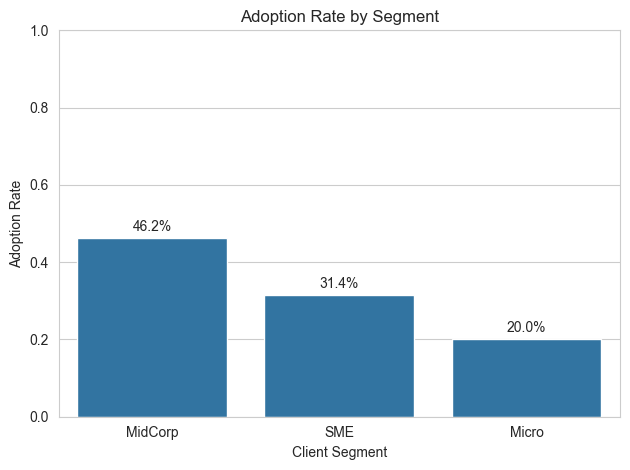


=== Adoption Rate by industry_name ===
           industry_name  adoption_rate
1           Construction       0.285714
4          Manufacturing       0.282685
6  Tech, Media & Telecom       0.281475
2     Financial Services       0.279772
0            Agriculture       0.277687
3  Hospitality & Tourism       0.276814
7  Transport & Logistics       0.274840
5     Retail & Wholesale       0.265442


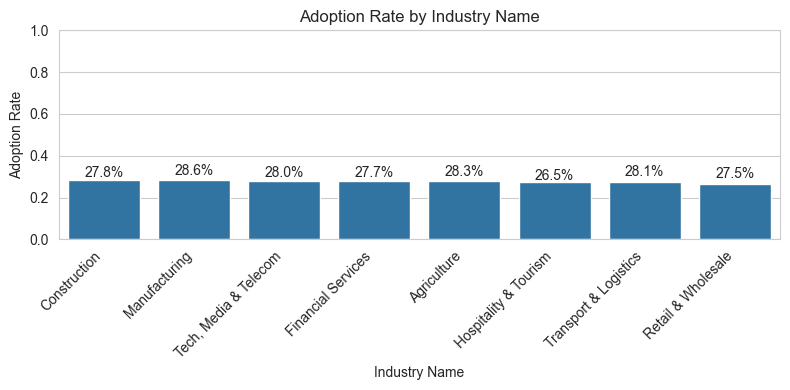

In [9]:
# ------- 0) Load cleaned tables -------
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

DATA_DIR = "./clean"  # change if your files are elsewhere

def _safe_read(name):
    # tries *_clean.csv then plain .csv
    p1 = os.path.join(DATA_DIR, f"{name}_clean.csv")
    p2 = os.path.join(DATA_DIR, f"{name}.csv")
    if os.path.exists(p1):
        print(f"Loaded {p1}")
        return pd.read_csv(p1)
    elif os.path.exists(p2):
        print(f"Loaded {p2}")
        return pd.read_csv(p2)
    else:
        raise FileNotFoundError(f"Could not find {name} CSV in {DATA_DIR}")

df_adoption = _safe_read("fact_product_adoption")
df_client   = _safe_read("dim_client")
df_industry = _safe_read("dim_industry")

# ------- 1) Ensure expected columns & dtypes -------
# IDs as object (string-like)
for col in ["client_sk", "industry_sk", "product_sk"]:
    if col in df_adoption.columns:
        df_adoption[col] = df_adoption[col].astype(str)
    if col in df_client.columns:
        df_client[col] = df_client[col].astype(str)
    if col in df_industry.columns:
        df_industry[col] = df_industry[col].astype(str)

# adoption flag as bool/int
if "adopted_flag" not in df_adoption.columns:
    # if not present, try to infer from adoption_date
    if "adoption_date" in df_adoption.columns:
        df_adoption["adopted_flag"] = df_adoption["adoption_date"].notna().astype(int)
    else:
        # fallback: assume not adopted
        df_adoption["adopted_flag"] = 0

# force numeric 0/1, then bool if you like
df_adoption["adopted_flag"] = pd.to_numeric(df_adoption["adopted_flag"], errors="coerce").fillna(0).clip(0,1)

# Some datasets use 'industry_name', others might have only code.
# Make sure we have a readable industry_name after the join.
if "industry_name" not in df_industry.columns and "industry_code" in df_industry.columns:
    df_industry["industry_name"] = df_industry["industry_code"]

# ------- 2) Merge for analysis -------
df_merge = (
    df_adoption.merge(df_client,   on="client_sk",   how="left", suffixes=("", "_client"))
               .merge(df_industry, on="industry_sk", how="left", suffixes=("", "_industry"))
)

print("Merged shape:", df_merge.shape)
print(df_merge[["client_sk","segment","industry_sk","industry_name","adopted_flag"]].head())

# ------- 3) Adoption by Segment -------
if {"segment","adopted_flag"}.issubset(df_merge.columns):
   adoption_by_segment = (
    df_merge.groupby("segment", dropna=False)["adopted_flag"]
            .mean()
            .reset_index()
            .rename(columns={"adopted_flag":"adoption_rate"})
            .sort_values("adoption_rate", ascending=False)
            .reset_index(drop=True)               # <- important
)

ax = sns.barplot(
    data=adoption_by_segment,
    x="segment",
    y="adoption_rate",
    order=adoption_by_segment["segment"]
)
plt.ylim(0,1)
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.text(x, y + 0.02, f"{y*100:.1f}%", ha="center")
plt.title("Adoption Rate by Segment")
plt.ylabel("Adoption Rate")
plt.xlabel("Client Segment")
plt.tight_layout()
plt.show()


# ------- 4) Adoption by Industry -------
industry_col = "industry_name" if "industry_name" in df_merge.columns else (
               "industry" if "industry" in df_merge.columns else None)

if industry_col and "adopted_flag" in df_merge.columns:
    adoption_by_industry = (
        df_merge.groupby(industry_col, dropna=False)["adopted_flag"]
                .mean()
                .reset_index()
                .rename(columns={"adopted_flag":"adoption_rate"})
                .sort_values("adoption_rate", ascending=False)
    )
    print(f"\n=== Adoption Rate by {industry_col} ===")
    print(adoption_by_industry)

    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=adoption_by_industry, x=industry_col, y="adoption_rate")
    plt.title(f"Adoption Rate by {industry_col.replace('_',' ').title()}")
    plt.ylabel("Adoption Rate")
    plt.xlabel(industry_col.replace('_',' ').title())
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0,1)
    for i, r in adoption_by_industry.iterrows():
        ax.text(i, r["adoption_rate"]+0.02, f"{r['adoption_rate']*100:.1f}%", ha="center")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Missing columns for industry analysis (need: 'adopted_flag' and an industry name column).")


=== Profile × Adoption Analysis ===

Adoption Rate by KYC Status:
  kyc_status  adoption_rate
0  Compliant       0.278765
1    Pending       0.275922
2     Review       0.270068

Formatted Results (KYC):
• Compliant ≈ 27.9%
• Pending ≈ 27.6%
• Review ≈ 27.0%


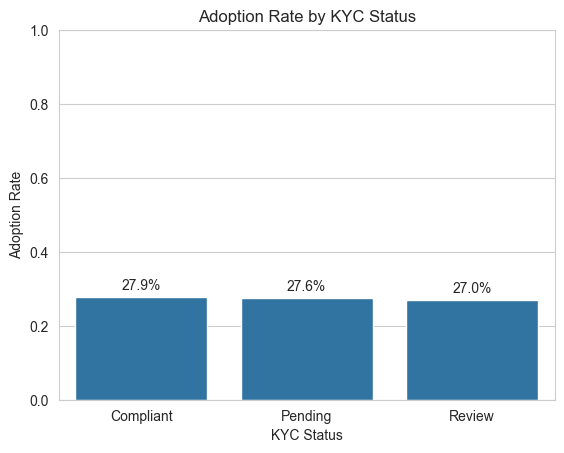


Adoption Rate by Years in Business Group:
   yib_group  adoption_rate
0    0–2 yrs       0.278228
1    3–5 yrs       0.279409
2   6–10 yrs       0.279144
3  11–20 yrs       0.236559
4    20+ yrs            NaN

Formatted Results (Years in Business):
• 0–2 yrs ≈ 27.8%
• 3–5 yrs ≈ 27.9%
• 6–10 yrs ≈ 27.9%
• 11–20 yrs ≈ 23.7%
• 20+ yrs ≈ nan%


/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/2461777766.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_merge.groupby("yib_group", dropna=False)["adopted_flag"]


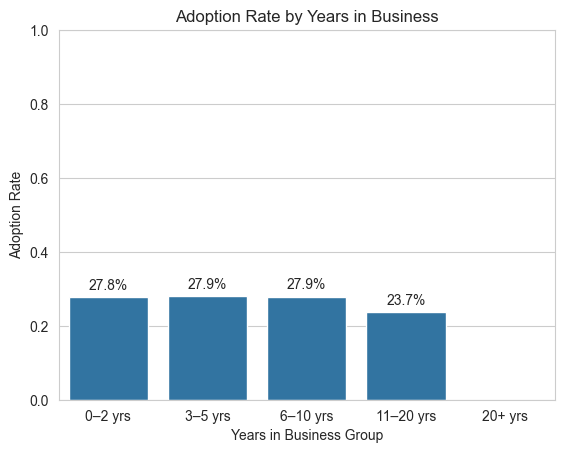


Adoption Rate by Employee Band:
  employees_band  adoption_rate
3         51-200       0.285668
1           200+       0.285632
2          21-50       0.278833
0            1-5       0.278276
4           6-20       0.274101

Formatted Results (Employee Band):
• 51-200 ≈ 28.6%
• 200+ ≈ 28.6%
• 21-50 ≈ 27.9%
• 1-5 ≈ 27.8%
• 6-20 ≈ 27.4%


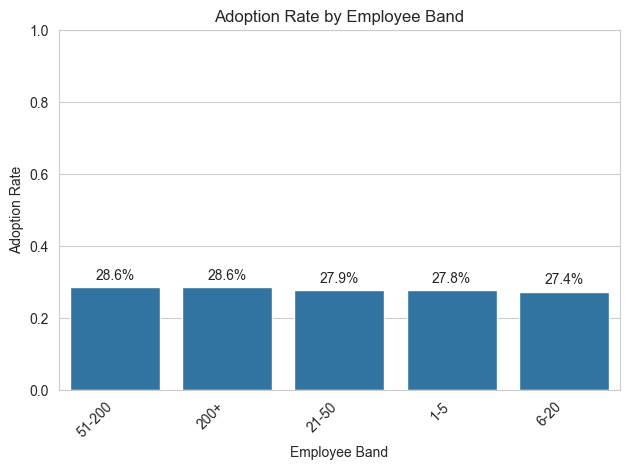

In [12]:
# ---------------- PROFILE × ADOPTION ----------------

print("\n=== Profile × Adoption Analysis ===")

# 1) KYC Verified vs Non-Verified
if {"kyc_status","adopted_flag"}.issubset(df_merge.columns):
    adoption_by_kyc = (
        df_merge.groupby("kyc_status", dropna=False)["adopted_flag"]
                .mean().reset_index()
                .rename(columns={"adopted_flag":"adoption_rate"})
                .sort_values("adoption_rate", ascending=False)
    )
    print("\nAdoption Rate by KYC Status:")
    print(adoption_by_kyc)

    print("\nFormatted Results (KYC):")
    for _, row in adoption_by_kyc.iterrows():
        print(f"• {row['kyc_status']} ≈ {row['adoption_rate']*100:.1f}%")

    ax = sns.barplot(data=adoption_by_kyc, x="kyc_status", y="adoption_rate")
    plt.title("Adoption Rate by KYC Status")
    plt.ylabel("Adoption Rate")
    plt.xlabel("KYC Status")
    plt.ylim(0,1)
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.text(x, y+0.02, f"{y*100:.1f}%", ha="center")
    plt.show()


# 2) Years in Business (grouped)
if {"years_in_business","adopted_flag"}.issubset(df_merge.columns):
    # Bin years into groups
    bins = [-1, 2, 5, 10, 20, 100]
    labels = ["0–2 yrs","3–5 yrs","6–10 yrs","11–20 yrs","20+ yrs"]
    df_merge["yib_group"] = pd.cut(df_merge["years_in_business"], bins=bins, labels=labels)

    adoption_by_yib = (
        df_merge.groupby("yib_group", dropna=False)["adopted_flag"]
                .mean().reset_index()
                .rename(columns={"adopted_flag":"adoption_rate"})
    )
    print("\nAdoption Rate by Years in Business Group:")
    print(adoption_by_yib)

    print("\nFormatted Results (Years in Business):")
    for _, row in adoption_by_yib.iterrows():
        print(f"• {row['yib_group']} ≈ {row['adoption_rate']*100:.1f}%")

    ax = sns.barplot(data=adoption_by_yib, x="yib_group", y="adoption_rate")
    plt.title("Adoption Rate by Years in Business")
    plt.ylabel("Adoption Rate")
    plt.xlabel("Years in Business Group")
    plt.ylim(0,1)
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.text(x, y+0.02, f"{y*100:.1f}%", ha="center")
    plt.show()


# 3) Employee Band
if {"employees_band","adopted_flag"}.issubset(df_merge.columns):
    adoption_by_emp = (
        df_merge.groupby("employees_band", dropna=False)["adopted_flag"]
                .mean().reset_index()
                .rename(columns={"adopted_flag":"adoption_rate"})
                .sort_values("adoption_rate", ascending=False)
    )
    print("\nAdoption Rate by Employee Band:")
    print(adoption_by_emp)

    print("\nFormatted Results (Employee Band):")
    for _, row in adoption_by_emp.iterrows():
        print(f"• {row['employees_band']} ≈ {row['adoption_rate']*100:.1f}%")

    ax = sns.barplot(data=adoption_by_emp, x="employees_band", y="adoption_rate")
    plt.title("Adoption Rate by Employee Band")
    plt.ylabel("Adoption Rate")
    plt.xlabel("Employee Band")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0,1)
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.text(x, y+0.02, f"{y*100:.1f}%", ha="center")
    plt.tight_layout()
    plt.show()

Loaded ./clean/fact_product_adoption_clean.csv
Loaded ./clean/dim_client_clean.csv
Loaded ./clean/dim_industry_clean.csv
df_merge shape (adoption + profile): (30000, 23)
  client_sk segment          industry_name  adopted_flag
0         1   Micro  Tech, Media & Telecom         False
1         1   Micro  Tech, Media & Telecom         False
2         1   Micro  Tech, Media & Telecom         False
3         1   Micro  Tech, Media & Telecom         False
4         1   Micro  Tech, Media & Telecom         False
Loaded ./clean/fact_client_monthly_clean.csv
df_merge shape after adding behavior: (30000, 28)
avg_balance: capped 0 low and 1290 high outliers to [-12,226.34, 75,994.92]
digital_logins_cnt: capped 0 low and 1278 high outliers to [-44.79, 131.79]
days_active: capped 0 low and 0 high outliers to [-0.29, 47.71]
email_open_rate: capped 84 low and 156 high outliers to [10.23, 31.48]
email_ctr: capped 0 low and 192 high outliers to [2.19, 12.38]

=== Behavior × Adoption Analysis ===

Aver

/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1143495274.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters", "Adopters"])


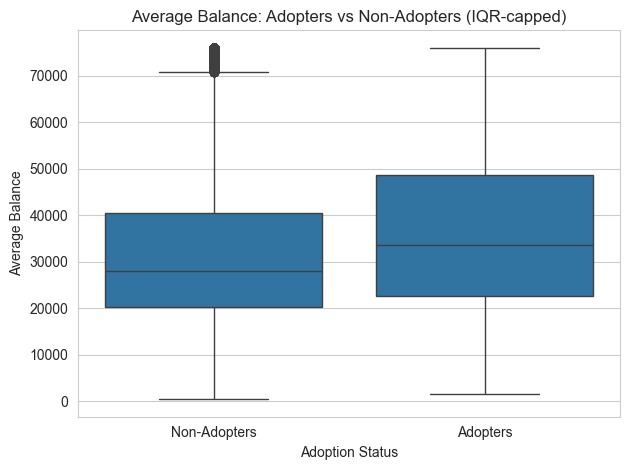


Digital Logins Comparison (after outlier clamping):
• Adopters:     59.92
• Non-Adopters: 46.79


/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1143495274.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters", "Adopters"])


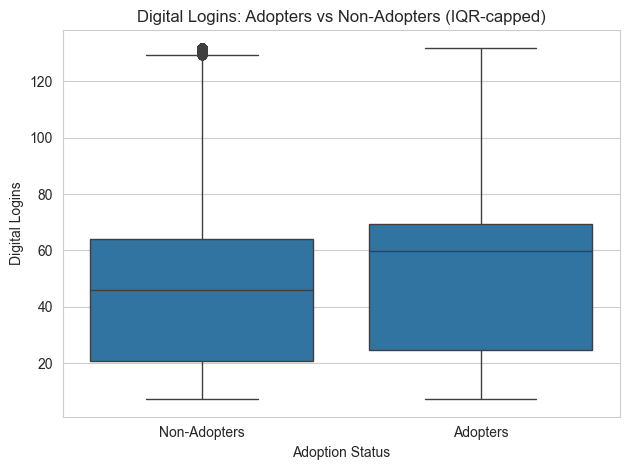

/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1143495274.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters", "Adopters"])



Days Active Comparison (after outlier clamping):
• Adopters:     25.62
• Non-Adopters: 23.43


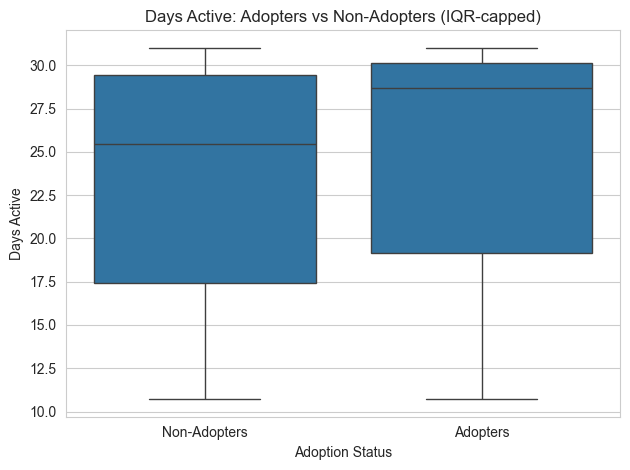


Email Open Rate (%) Comparison (after outlier clamping):
• Adopters:     20.83
• Non-Adopters: 20.94


/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1143495274.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters", "Adopters"])


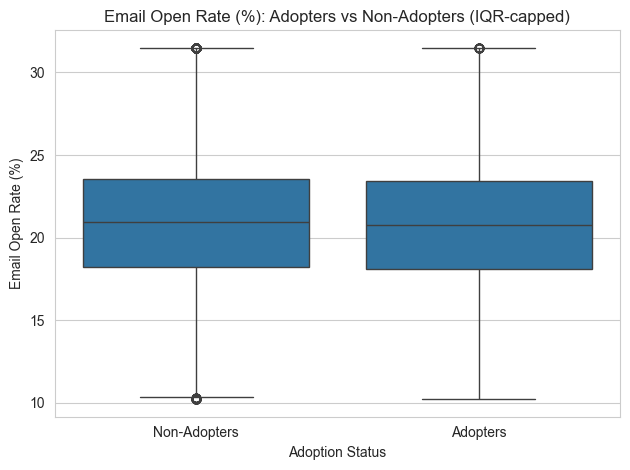


Email Click-Through Rate (%) Comparison (after outlier clamping):
• Adopters:     7.31
• Non-Adopters: 7.34


/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1143495274.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters", "Adopters"])


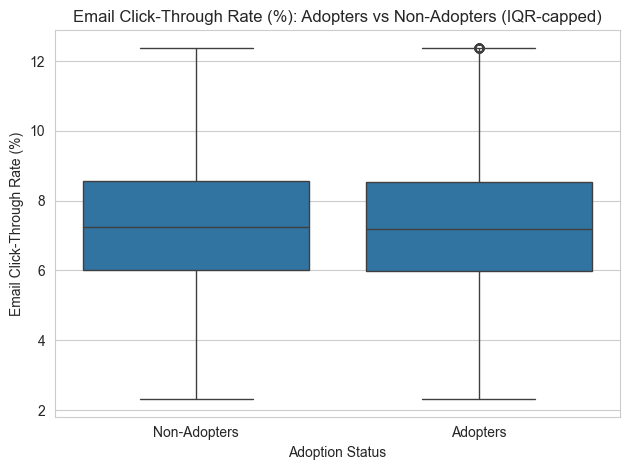


Correlation with adoption (Pearson, post-clamping):
digital_logins_cnt    0.178
days_active           0.158
avg_balance           0.135
email_open_rate      -0.013
email_ctr            -0.008
Name: adopted_flag, dtype: float64


In [17]:
# ========================= BEHAVIOR × ADOPTION (WITH OUTLIER CLAMPING) =========================
# Loads: dim_client, dim_industry, fact_product_adoption, fact_client_monthly
# Builds df_merge (adoption + profile), aggregates behaviour to client level,
# clamps outliers on behavioural columns using IQR caps, then runs comparisons and correlations.
# =================================================================================================

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# -------- CONFIG --------
DATA_DIR = "./clean"  # change if your files live elsewhere (e.g., "data")

def _safe_read(name):
    p1 = os.path.join(DATA_DIR, f"{name}_clean.csv")
    p2 = os.path.join(DATA_DIR, f"{name}.csv")
    if os.path.exists(p1):
        print(f"Loaded {p1}")
        return pd.read_csv(p1)
    if os.path.exists(p2):
        print(f"Loaded {p2}")
        return pd.read_csv(p2)
    raise FileNotFoundError(f"Could not find {name} in {DATA_DIR}")

def as_object_key(s: pd.Series) -> pd.Series:
    tmp = pd.to_numeric(s, errors="coerce").astype("Int64").astype(str)
    return tmp.replace("<NA>", "").astype(object)

def cap_outliers_iqr(df: pd.DataFrame, cols: list[str], verbose: bool = True) -> pd.DataFrame:
    """
    Caps numeric columns at IQR bounds:
      lower = Q1 - 1.5*IQR, upper = Q3 + 1.5*IQR
    Returns a new DataFrame with capped values.
    """
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            if verbose:
                print(f"Skipping outlier cap for {c}: column not in DataFrame.")
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        if s.dropna().empty:
            if verbose:
                print(f"Skipping outlier cap for {c}: no numeric data.")
            continue
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        before_low = (s < lo).sum()
        before_hi  = (s > hi).sum()
        df[c] = s.clip(lower=lo, upper=hi)
        if verbose:
            print(f"{c}: capped {before_low} low and {before_hi} high outliers "
                  f"to [{lo:,.2f}, {hi:,.2f}]")
    return df

# -------- 0) Load core tables for merge (adoption + profile) --------
df_adoption = _safe_read("fact_product_adoption")
df_client   = _safe_read("dim_client")
df_industry = _safe_read("dim_industry")

# Normalize keys as object (string-like) for consistent joins
for col in ["client_sk", "industry_sk", "product_sk"]:
    if col in df_adoption.columns: df_adoption[col] = as_object_key(df_adoption[col])
    if col in df_client.columns:   df_client[col]   = as_object_key(df_client[col])
    if col in df_industry.columns: df_industry[col] = as_object_key(df_industry[col])

# Ensure adopted_flag exists and is numeric 0/1
if "adopted_flag" not in df_adoption.columns:
    if "adoption_date" in df_adoption.columns:
        df_adoption["adopted_flag"] = df_adoption["adoption_date"].notna().astype(int)
    else:
        df_adoption["adopted_flag"] = 0
df_adoption["adopted_flag"] = pd.to_numeric(df_adoption["adopted_flag"], errors="coerce").fillna(0).clip(0, 1)

# If industry_name missing, fallback to industry_code
if "industry_name" not in df_industry.columns and "industry_code" in df_industry.columns:
    df_industry["industry_name"] = df_industry["industry_code"]

# Build df_merge: adoption + client profile + industry
df_merge = (
    df_adoption
      .merge(df_client,   on="client_sk",   how="left", suffixes=("", "_client"))
      .merge(df_industry, on="industry_sk", how="left", suffixes=("", "_industry"))
)

print("df_merge shape (adoption + profile):", df_merge.shape)
print(df_merge[["client_sk","segment","industry_name","adopted_flag"]].head())

# -------- 1) Load and prepare behavior (fact_client_monthly) --------
df_fcm = _safe_read("fact_client_monthly")

beh_cols = [
    "client_sk",
    "avg_balance",
    "digital_logins_cnt",
    "days_active",
    "email_open_rate",
    "email_ctr",
]

# Aggregate multiple months per client to client-level behaviour
if "month_sk" in df_fcm.columns:
    if "client_sk" in df_fcm.columns:
        df_fcm["client_sk"] = pd.to_numeric(df_fcm["client_sk"], errors="coerce")
    df_beh = (
        df_fcm.groupby("client_sk", as_index=False)[
            [c for c in beh_cols if c != "client_sk" and c in df_fcm.columns]
        ].mean(numeric_only=True)
    )
else:
    df_beh = df_fcm[[c for c in beh_cols if c in df_fcm.columns]].copy()

# Align join key dtype to object on both sides
if "client_sk" in df_beh.columns:
    df_beh["client_sk"] = as_object_key(df_beh["client_sk"])
df_merge["client_sk"] = as_object_key(df_merge["client_sk"])

# Merge behaviors into df_merge
df_merge = df_merge.merge(df_beh, on="client_sk", how="left")
print("df_merge shape after adding behavior:", df_merge.shape)

# -------- 2) Clamp outliers on behavioural columns (IQR caps) --------
behaviour_to_cap = [c for c in ["avg_balance","digital_logins_cnt","days_active","email_open_rate","email_ctr"]
                    if c in df_merge.columns]
df_merge = cap_outliers_iqr(df_merge, behaviour_to_cap, verbose=True)

print("\n=== Behavior × Adoption Analysis ===")

# Helper: compare a numeric behavior between adopters vs non-adopters, with plot
def compare_behavior(col: str, label: str = None):
    label = label or col
    needed = {col, "adopted_flag"}
    if not needed.issubset(df_merge.columns):
        print(f"Skipping {label}: missing columns {needed - set(df_merge.columns)}")
        return
    adopters = df_merge.loc[df_merge["adopted_flag"] == 1, col].dropna()
    non_adopters = df_merge.loc[df_merge["adopted_flag"] == 0, col].dropna()
    print(f"\n{label} Comparison (after outlier clamping):")
    print(f"• Adopters:     {adopters.mean():,.2f}")
    print(f"• Non-Adopters: {non_adopters.mean():,.2f}")

    ax = sns.boxplot(data=df_merge, x="adopted_flag", y=col)
    ax.set_xticklabels(["Non-Adopters", "Adopters"])
    plt.title(f"{label}: Adopters vs Non-Adopters (IQR-capped)")
    plt.ylabel(label)
    plt.xlabel("Adoption Status")
    plt.tight_layout()
    plt.show()

# -------- 3) Balance vs Adoption --------
compare_behavior("avg_balance", label="Average Balance")

# -------- 4) Digital activity vs Adoption --------
compare_behavior("digital_logins_cnt", label="Digital Logins")
compare_behavior("days_active", label="Days Active")

# -------- 5) Email engagement vs Adoption --------
compare_behavior("email_open_rate", label="Email Open Rate (%)")
compare_behavior("email_ctr",       label="Email Click-Through Rate (%)")

# -------- 6) Quick correlations with adoption (post-clamping) --------
num_cols = [c for c in ["avg_balance","digital_logins_cnt","days_active","email_open_rate","email_ctr"]
            if c in df_merge.columns]
if num_cols and "adopted_flag" in df_merge.columns:
    corr = df_merge[num_cols + ["adopted_flag"]].corr(numeric_only=True)["adopted_flag"] \
           .drop("adopted_flag", errors="ignore") \
           .sort_values(key=abs, ascending=False)
    print("\nCorrelation with adoption (Pearson, post-clamping):")
    print(corr.round(3))


=== Segment × Industry Adoption Analysis ===

=== SME Adoption Rate by Industry ===
           industry_name  adoption_rate
2     Financial Services       0.324308
1           Construction       0.324254
0            Agriculture       0.321605
6  Tech, Media & Telecom       0.321181
4          Manufacturing       0.318579
7  Transport & Logistics       0.305736
3  Hospitality & Tourism       0.302768
5     Retail & Wholesale       0.298561

Formatted Results (SMEs):
• Financial Services ≈ 32.4%
• Construction ≈ 32.4%
• Agriculture ≈ 32.2%
• Tech, Media & Telecom ≈ 32.1%
• Manufacturing ≈ 31.9%
• Transport & Logistics ≈ 30.6%
• Hospitality & Tourism ≈ 30.3%
• Retail & Wholesale ≈ 29.9%


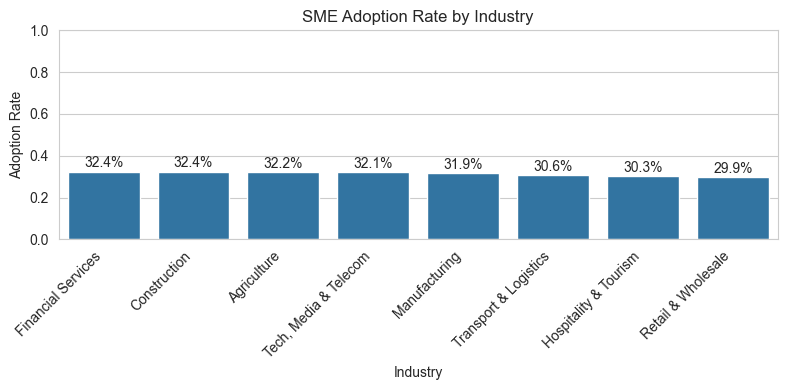

In [25]:
# ---------------- SEGMENT × INDUSTRY (DOUBLE CATEGORIES) ----------------
print("\n=== Segment × Industry Adoption Analysis ===")

# Ensure required columns exist
required_cols = {"segment", "industry_name", "adopted_flag"}
if not required_cols.issubset(df_merge.columns):
    raise RuntimeError(f"Missing columns: {required_cols - set(df_merge.columns)}")

# 1) SME adoption by industry
sme_industry = (
    df_merge.loc[df_merge["segment"] == "SME"]
            .groupby("industry_name")["adopted_flag"]
            .mean()
            .reset_index()
            .rename(columns={"adopted_flag":"adoption_rate"})
            .sort_values("adoption_rate", ascending=False)
)
print("\n=== SME Adoption Rate by Industry ===")
print(sme_industry)

print("\nFormatted Results (SMEs):")
for _, row in sme_industry.iterrows():
    print(f"• {row['industry_name']} ≈ {row['adoption_rate']*100:.1f}%")

plt.figure(figsize=(8,4))
ax = sns.barplot(data=sme_industry, x="industry_name", y="adoption_rate")
plt.title("SME Adoption Rate by Industry")
plt.ylabel("Adoption Rate")
plt.xlabel("Industry")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1)
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.text(x, y+0.02, f"{y*100:.1f}%", ha="center")
plt.tight_layout()
plt.show()




df_merge shape (Segment × Behavior ready): (30000, 29)

SME: Average Balance Comparison
• Adopters:     38,695.90
• Non-Adopters: 38,405.61


/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1462563357.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters","Adopters"])


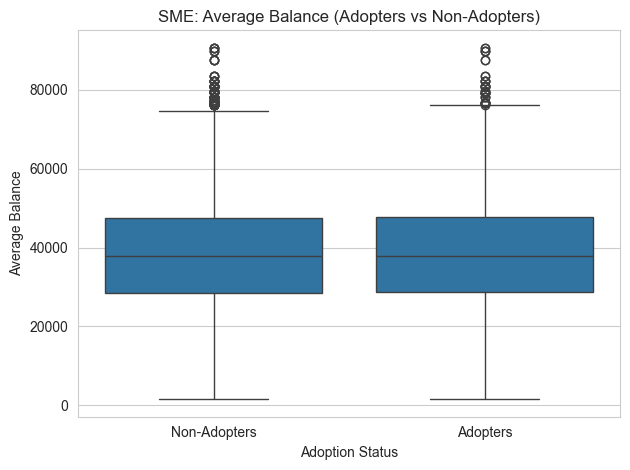


Corporate: Digital Logins Comparison
• Adopters:     130.32
• Non-Adopters: 130.30


/var/folders/l_/fty85h0d2klg_8xpvhpbtw2w0000gn/T/ipykernel_4358/1462563357.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Adopters","Adopters"])


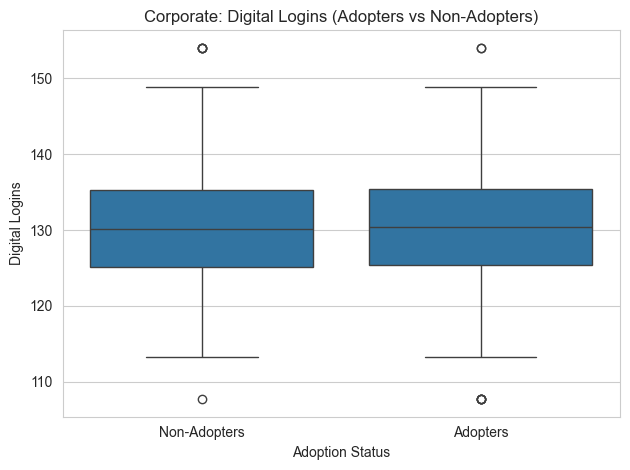

In [28]:

# ---------------- SEGMENT × BEHAVIOR (FULL EXTENSION) ----------------
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

DATA_DIR = "./clean"  # adjust if needed

def _safe_read(name):
    p1 = os.path.join(DATA_DIR, f"{name}_clean.csv")
    p2 = os.path.join(DATA_DIR, f"{name}.csv")
    if os.path.exists(p1): return pd.read_csv(p1)
    if os.path.exists(p2): return pd.read_csv(p2)
    raise FileNotFoundError(f"{name} not found in {DATA_DIR}")

def as_object_key(s: pd.Series) -> pd.Series:
    tmp = pd.to_numeric(s, errors="coerce").astype("Int64").astype(str)
    return tmp.replace("<NA>", "").astype(object)

# --- Load required tables ---
df_adoption = _safe_read("fact_product_adoption")
df_client   = _safe_read("dim_client")
df_industry = _safe_read("dim_industry")
df_fcm      = _safe_read("fact_client_monthly")

# --- Normalize keys ---
for df in [df_adoption, df_client, df_industry, df_fcm]:
    if "client_sk" in df.columns:
        df["client_sk"] = as_object_key(df["client_sk"])

# --- Ensure adopted_flag exists ---
if "adopted_flag" not in df_adoption.columns:
    if "adoption_date" in df_adoption.columns:
        df_adoption["adopted_flag"] = df_adoption["adoption_date"].notna().astype(int)
    else:
        df_adoption["adopted_flag"] = 0
df_adoption["adopted_flag"] = pd.to_numeric(df_adoption["adopted_flag"], errors="coerce").fillna(0).clip(0,1)

# --- Add segment normalization ---
seg_map = {"corporate":"Corporate","midcorp":"Corporate","corp":"Corporate",
           "sme":"SME","small medium enterprise":"SME",
           "micro":"Micro","micro sme":"Micro"}
df_client["segment_norm"] = (
    df_client["segment"].astype(str).str.strip().str.lower().map(seg_map)
    .fillna(df_client["segment"].astype(str).str.strip().str.title())
)

# --- Aggregate monthly behaviours to client-level ---
beh_cols = ["avg_balance","digital_logins_cnt","days_active","email_open_rate","email_ctr"]
df_beh = (
    df_fcm.groupby("client_sk", as_index=False)[[c for c in beh_cols if c in df_fcm.columns]]
          .mean(numeric_only=True)
)

# --- Merge all together ---
df_merge = (
    df_adoption.merge(df_client, on="client_sk", how="left")
               .merge(df_industry, on="industry_sk", how="left")
               .merge(df_beh, on="client_sk", how="left")
)

print("df_merge shape (Segment × Behavior ready):", df_merge.shape)

# ---------------- ANALYSIS ----------------
def compare_segment_behavior(segment: str, col: str, label: str = None):
    label = label or col
    seg_df = df_merge[df_merge["segment_norm"] == segment].copy()
    if seg_df.empty:
        print(f"\nNo rows for segment = {segment}")
        return
    adopters = seg_df.loc[seg_df["adopted_flag"] == 1, col].dropna()
    non_adopters = seg_df.loc[seg_df["adopted_flag"] == 0, col].dropna()
    if adopters.empty or non_adopters.empty:
        print(f"\nNot enough rows for {segment} on {label}")
        return
    print(f"\n{segment}: {label} Comparison")
    print(f"• Adopters:     {adopters.mean():,.2f}")
    print(f"• Non-Adopters: {non_adopters.mean():,.2f}")

    ax = sns.boxplot(data=seg_df, x="adopted_flag", y=col)
    ax.set_xticklabels(["Non-Adopters","Adopters"])
    plt.title(f"{segment}: {label} (Adopters vs Non-Adopters)")
    plt.ylabel(label)
    plt.xlabel("Adoption Status")
    plt.tight_layout()
    plt.show()

# 1) SMEs: higher balances?
compare_segment_behavior("SME", "avg_balance", label="Average Balance")

# 2) Corporates: digital logins?
compare_segment_behavior("Corporate", "digital_logins_cnt", label="Digital Logins")


=== Time Dimension Adoption Analysis ===

Adoption Rate by Month:
   month_sk  adopted_flag month_label  quarter_num  year_num
0  202301.0           1.0     2023-01            1      2023
1  202302.0           1.0     2023-02            1      2023
2  202303.0           1.0     2023-03            1      2023
3  202304.0           1.0     2023-04            2      2023
4  202305.0           1.0     2023-05            2      2023


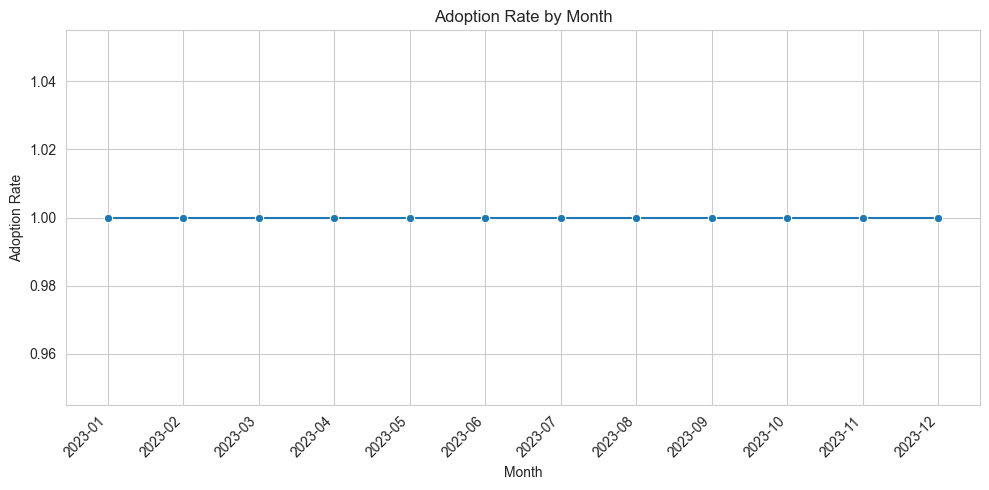


Adoption Rate by Quarter:
   year_num  quarter_num  adopted_flag
0      2023            1           1.0
1      2023            2           1.0
2      2023            3           1.0
3      2023            4           1.0


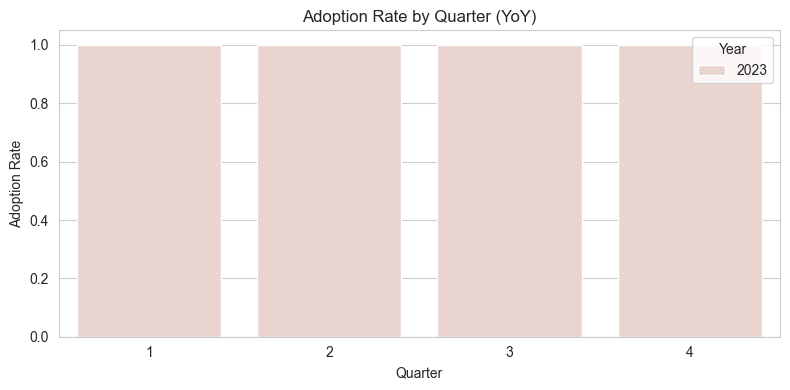


Year-end (Dec/Jan) Adoption Rates:
month_label
2023-01    1.0
2023-12    1.0
Name: adopted_flag, dtype: float64


In [29]:
# ---------------- TIME DIMENSION ANALYSIS ----------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== Time Dimension Adoption Analysis ===")

# --- Load time-related tables ---
df_dim_time  = _safe_read("dim_time")
df_dim_month = _safe_read("dim_month")
df_campaign  = _safe_read("dim_campaign")   # optional, for campaign link

# Ensure keys are aligned
df_adoption["adoption_date"] = pd.to_datetime(df_adoption.get("adoption_date"))
df_dim_time["calendar_date"] = pd.to_datetime(df_dim_time["calendar_date"])
df_dim_month["month_start"]  = pd.to_datetime(df_dim_month["month_start"])

# --- Link adoption to month/quarter ---
adopt_time = (
    df_adoption.merge(df_dim_time, left_on=df_adoption["adoption_date"].dt.strftime("%Y%m%d"),
                      right_on=df_dim_time["date_sk"].astype(str),
                      how="left")
)

# Adoption rate per month
adopt_by_month = (
    adopt_time.groupby("month_sk")["adopted_flag"].mean().reset_index()
              .merge(df_dim_month[["month_sk","month_label","quarter_num","year_num"]],
                     on="month_sk", how="left")
              .sort_values("month_sk")
)

print("\nAdoption Rate by Month:")
print(adopt_by_month.head())

plt.figure(figsize=(10,5))
sns.lineplot(data=adopt_by_month, x="month_label", y="adopted_flag", marker="o")
plt.title("Adoption Rate by Month")
plt.ylabel("Adoption Rate")
plt.xlabel("Month")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Adoption by quarter ---
adopt_by_qtr = (
    adopt_by_month.groupby(["year_num","quarter_num"])["adopted_flag"]
                  .mean().reset_index()
)
print("\nAdoption Rate by Quarter:")
print(adopt_by_qtr)

plt.figure(figsize=(8,4))
sns.barplot(data=adopt_by_qtr, x="quarter_num", y="adopted_flag", hue="year_num")
plt.title("Adoption Rate by Quarter (YoY)")
plt.ylabel("Adoption Rate")
plt.xlabel("Quarter")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

# --- Year-end seasonality (Dec/Jan) ---
adopt_by_month["month_num"] = adopt_by_month["month_label"].str[-2:].astype(int)
yearend = adopt_by_month[adopt_by_month["month_num"].isin([12,1])]
print("\nYear-end (Dec/Jan) Adoption Rates:")
print(yearend.groupby("month_label")["adopted_flag"].mean())

# --- Adoption vs Campaigns/Events ---
if "last_campaign_sk" in df_adoption.columns:
    adopt_campaign = (
        df_adoption.merge(df_campaign, left_on="last_campaign_sk", right_on="campaign_sk", how="left")
                   .groupby("campaign_name")["adopted_flag"].mean().reset_index()
                   .sort_values("adopted_flag", ascending=False)
    )
    print("\nAdoption Rate by Campaign/Event:")
    print(adopt_campaign.head(10))

    plt.figure(figsize=(8,4))
    sns.barplot(data=adopt_campaign.head(10), x="campaign_name", y="adopted_flag")
    plt.title("Top 10 Campaigns by Adoption Rate")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Adoption Rate")
    plt.tight_layout()
    plt.show()